In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft
from scipy.special import expit
from theano import shared

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


The `Recall.csv` dataset is from Oberauer (2019) which investigate the capacity of working memory. In this study, each subject was presented word lists with different lengths (containing 2, 4, 6 and 8 words). Afterwards, they were asked to recall a word given its position in the list. Figure shows an example of set size 4. 

<!-- ![](./fig_memory.png) -->
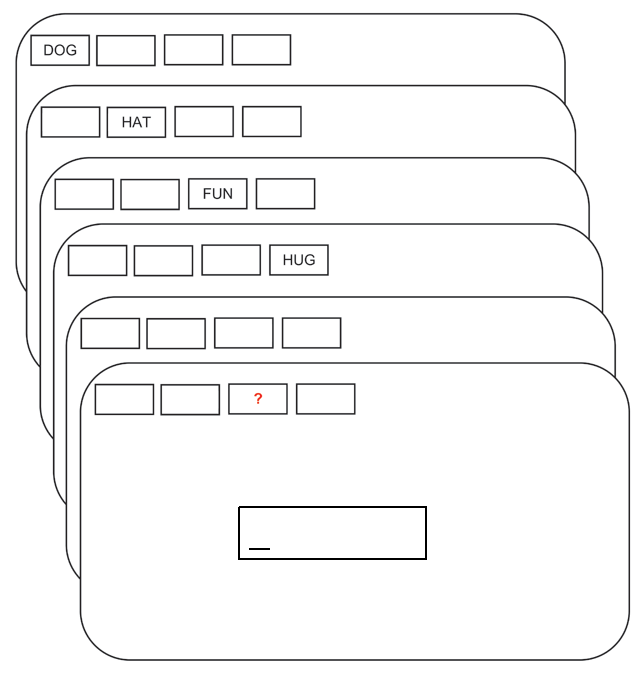

The dataset contains the following variables:

- `set_size`: the number of words shown to the subject
- `correct`: 1 if the answer was correct, 0 otherwise
- `tested`: the position of the word asked
- The other variables in the dataset indicates the subject, trial, session and block ids.


> Oberauer, Klaus. 2019. “Working Memory Capacity Limits Memory for Bindings.” Journal of Cognition 2 (1): 40. https://doi.org/10.5334/joc.86

In [3]:
d = pd.read_csv("Recall.csv")

In [4]:
d.head()

,subj,set_size,correct,trial,session,block,tested
0,10,4,1,1,1,1,2
1,10,8,0,4,1,1,8
2,10,2,1,9,1,1,2
3,10,6,1,23,1,1,2
4,10,4,1,5,1,2,3


It is known that as the number of items to be held in working memory increase (`set_size` or $S$), the accuracy decraease (`correct` or $C$). The number of items shown ($S$) also affects where the test item will be (`tested` or $T$). Finally, the location of the test item ($T$) can also affect accuracy ($C$) as items that are shown later can be easier to remember. 

1. Draw a DAG for this problem using the `daft` package.

<Axes:>

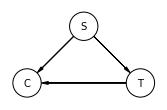

In [5]:
# your code here
pgm = daft.PGM()
pgm.add_node("S","S",1,2)
pgm.add_node("C","C",0,1)
pgm.add_node("T","T",2,1)
pgm.add_edge("S", "C")
pgm.add_edge("S", "T")
pgm.add_edge("T", "C")
pgm.render()

1. Estimate the **total effect** of `set_size` on `correct`. Note that, the outcome variable is a categorical 0/1 variable. You should follow the Bayesian workflow when approching this problem, which includes:
- Scale your inputs when necessary.
- Do prior predictive simulation to choose suitable priors
- Compute the posteriors
- Ensure that your MCMC samples from the posterior using suitable graphical tools and metrics for assessment.
- Describe how the posterior parameters should be interpreted(making suitable transformations when necessary)
- Run posterior predictive simulation and describe the results

In [6]:
# First standardize the data

d["s"]=(d.set_size-d.set_size.mean())/d.set_size.std()
d["t"]=(d.tested-d.tested.mean())/d.tested.std()
d.head()

,subj,set_size,correct,trial,session,block,tested,s,t
0,10,4,1,1,1,1,2,-0.444776,-0.498848
1,10,8,0,4,1,1,8,1.334329,2.560754
2,10,2,1,9,1,1,2,-1.334329,-0.498848
3,10,6,1,23,1,1,2,0.444776,-0.498848
4,10,4,1,5,1,2,3,-0.444776,0.011086


$$
\begin{align*} 
C_i &\sim \text{Bernoulli}(p_i)
\\
logit(p_i) &= \beta_s S_i  
\\
\color{black}{\beta_s\ } &\color{black}{\sim \text{Normal}(0,0.2)} \end{align*}$$


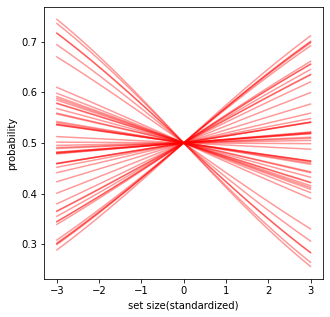

In [7]:
#Lets generate model for total effect and look at the priors. 
#I use the expit funciton to take the invlogit of prior pred model. It is the same as pm.math.invlogit function. 
#pm.math.invlogit didn't work while taking the inverse logit of 'prior_pred_model_total['beta_s'][i,] * Sseq'. That's why I use 'expit'

with pm.Model() as model_total:
    beta_s = pm.Normal('beta_s', mu = 0, sigma = 0.2)
    p_i =  pm.math.invlogit(beta_s*d.s)
    prior_pred_model_total = pm.sample_prior_predictive()
    
Sseq = np.linspace(-3, 3, 30)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = expit(prior_pred_model_total['beta_s'][i,] * Sseq)
    ax.plot(Sseq, y, "r", alpha = 0.4) 
    ax.set_xlabel("set size(standardized)")
    ax.set_ylabel("probability")

#This prior looks okey in the figure below.

In [8]:
#Now,lets do the posterior predictive analysis

with pm.Model() as model_total:
    beta_s = pm.Normal('beta_s', mu = 0, sigma = 0.2)
    p_i =  pm.math.invlogit(beta_s*d.s)
    C = pm.Bernoulli('c', p_i, observed = d.correct)
    trace_model_total = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [9]:
az.summary(trace_model_total, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
beta_s,-0.266,0.142,-0.541,-0.011


#Beta of set size has an negative sign. It means that set size is negatively correlated with probability of correctness.

In [10]:
az.summary(trace_model_total, kind = "diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_s,0.003,0.002,1718.0,2939.0,1.0


array([[<AxesSubplot:title={'center':'beta_s'}>,
        <AxesSubplot:title={'center':'beta_s'}>]], dtype=object)

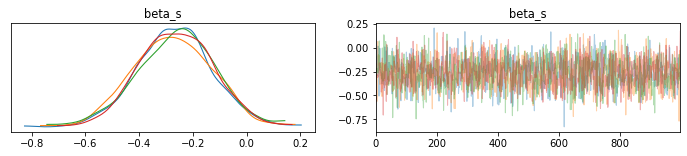

In [11]:
az.plot_trace(trace_model_total, compact=False)
 

array([[<AxesSubplot:title={'center':'beta_s'}>,
        <AxesSubplot:title={'center':'beta_s'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

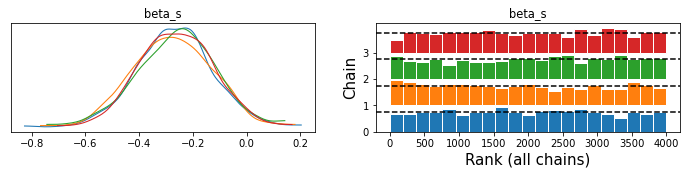

In [12]:
 az.plot_trace(trace_model_total, kind="rank_bars", compact=False)

- What is the difference of probability of correct answer (contrast) between showing 6 and 2 items to the participants? (Simulate interventions for these two conditions with your posteriors, and show the contrast distribution using a suitable graph)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


Text(-0.35, 1, '97%')

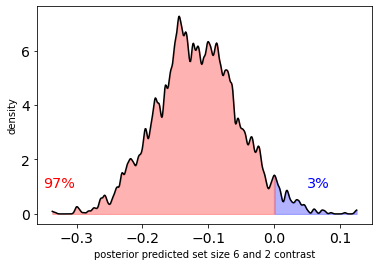

In [13]:
set_size_shared = shared(d.s.values)

with pm.Model() as model_total:
    beta_s = pm.Normal('beta_s', mu = 0, sigma = 0.2)
    p_i =  pm.Deterministic('p_i', pm.math.invlogit(beta_s*set_size_shared))
    C = pm.Bernoulli('c', p_i, observed = d.correct)
    trace_model_total = pm.sample(1000, tune = 1000, return_inferencedata=True)

#Here, I multiply with 0.44 which is the standardized value of 6    
set_size_6 = np.ones(len(d),dtype = int)*0.44
set_size_shared.set_value(set_size_6)

with model_total:
    pred_6 = pm.sample_posterior_predictive(trace_model_total, var_names = ["p_i"])

#Here, I multiply with -1.33 which is the standardized value of 2    
set_size_2 = np.ones(len(d),dtype = int)*-1.33
set_size_shared.set_value(set_size_2)

with model_total:
    pred_2 = pm.sample_posterior_predictive(trace_model_total, var_names = ["p_i"])
    
ax = az.plot_dist(pred_6["p_i"] - pred_2["p_i"], color = "k" )
ax.set_xlabel("posterior predicted set size 6 and 2 contrast")
ax.set_ylabel("density")

l1 = ax.lines[0]
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
ax.fill_between(x1[x1>0],y1[x1>0], color="blue", alpha=0.3)
ax.fill_between(x1[x1<0],y1[x1<0], color="red", alpha=0.3)
ax.text(0.05,1,"{0:.0f}%".format(np.mean((pred_6["p_i"] - pred_2["p_i"])>0) * 100), color = "blue", fontsize= "x-large")
ax.text(-0.35,1,"{0:.0f}%".format(np.mean((pred_2["p_i"] - pred_6["p_i"])>0) * 100), color = "red", fontsize= "x-large")



As seen above, intervention of size 2 has a higher posterior probability distribution for correct answer than than the intervantion of the size 6. 

2. Estimate the **direct effect** of `set_size` on `correct` by following the Bayesian workflow. Describe how the posterior parameters should be interpreted(making suitable transformations when necessary)

$$
\begin{align*} 
C_i &\sim \text{Bernoulli}(p_i)
\\
logit(p_i) &= \beta_s S_i + \beta_t T_i 
\\
\color{black}{\beta_s\ } &\color{black}{\sim \text{Normal}(0,0.2)} 
\\
\color{black}{\beta_t\ } &\color{black}{\sim \text{Normal}(0,0.1)} 
\end{align*}$$

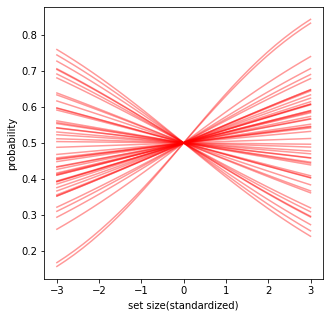

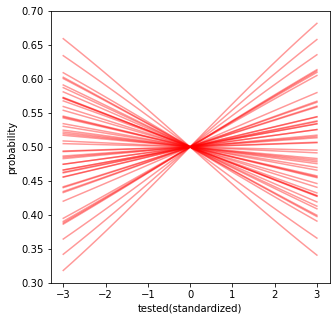

In [14]:
#Lets first do the prior predictive analysis

with pm.Model() as model_direct:
    beta_s = pm.Normal('beta_s', mu = 0, sigma = 0.2)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.1)
    p_i =  pm.math.invlogit(beta_s*d.s + beta_t*d.t)
    prior_pred_model_direct = pm.sample_prior_predictive()

#Prior analysis for beta of set size:

Sseq = np.linspace(-3, 3, 30)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = expit(prior_pred_model_direct['beta_s'][i,] * Sseq )
    ax.plot(Sseq, y, "r", alpha = 0.4) 
    ax.set_xlabel("set size(standardized)")
    ax.set_ylabel("probability")  

#Prior analysis for beta of test

Tseq = np.linspace(-3, 3, 30)
fig, at = plt.subplots(figsize=(5,5))    
for i in range(50):
    z = expit(prior_pred_model_direct['beta_t'][i,] * Tseq )
    at.plot(Tseq, z, "r", alpha = 0.4) 
    at.set_xlabel("tested(standardized)")
    at.set_ylabel("probability") 

In [15]:
#Posterior Predictive Analysis

with pm.Model() as model_direct:
    beta_s = pm.Normal('beta_s', mu = 0, sigma = 0.2)
    beta_t = pm.Normal('beta_t', mu = 0, sigma = 0.1)
    p_i =  pm.math.invlogit(beta_s*d.s + beta_t*d.t)
    C = pm.Bernoulli('c', p_i, observed = d.correct)
    trace_model_direct = pm.sample(1000, tune = 1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_t, beta_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [16]:
az.summary(trace_model_direct, kind = "stats")

,mean,sd,hdi_3%,hdi_97%
beta_s,-0.258,0.148,-0.517,0.035
beta_t,-0.012,0.094,-0.174,0.171


#Beta of set size has an negative sign. It means that set size is negatively correlated with probability of correctness.

#Beta of test is approximately zero. It means that test has no effect on probability of correctness.

In [17]:
az.summary(trace_model_direct, kind = "diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_s,0.003,0.002,3167.0,2790.0,1.0
beta_t,0.002,0.002,3282.0,2765.0,1.0


array([[<AxesSubplot:title={'center':'beta_s'}>,
        <AxesSubplot:title={'center':'beta_s'}>],
       [<AxesSubplot:title={'center':'beta_t'}>,
        <AxesSubplot:title={'center':'beta_t'}>]], dtype=object)

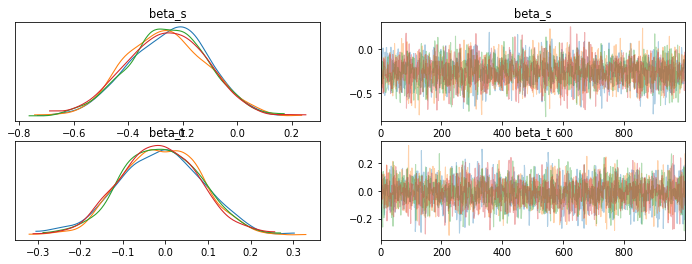

In [18]:
az.plot_trace(trace_model_direct, compact=False)

array([[<AxesSubplot:title={'center':'beta_s'}>,
        <AxesSubplot:title={'center':'beta_s'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'beta_t'}>,
        <AxesSubplot:title={'center':'beta_t'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

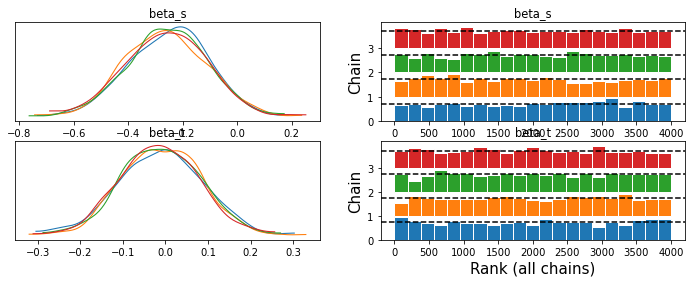

In [19]:
 az.plot_trace(trace_model_direct, kind="rank_bars", compact=False)

3. Compare the models you used for estimating the *total effect* and *direct effect* by using WAIC as your comparison measure. Discuss the predictive performance of these two models based on this.  

In [20]:
compare_waic = az.compare({'$S$':trace_model_total, '$S + T$':trace_model_direct},
    scale="deviance",
    ic = "waic")
compare_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
$S$,0,123.396143,0.437572,0.00000,1.0,2.433791,0.000000,False,deviance
$S + T$,1,123.816923,0.602063,0.42078,0.0,2.431530,0.114648,False,deviance


#When we compare total effect and direct effect, their WAIC values are so close to each other. So we cannot say a certain thing about their predictive performance. 

You may add more code or markdown blocks above between the questions as you see necessary.